# Traditional Time Series Modeling

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
# import statsmodels.api as sm #cannot find factorial
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import acf, pacf 
from datetime import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
rcParams['figure.figsize'] = 15, 6

#### Create main dataframe

In [5]:
#Import, sort and filter, describe
df = pd.read_csv('full_series.csv',index_col="Date",parse_dates=True)
df = df.sort_index(ascending = True)
df = df[(df.index >= '2017-01-01')] # remove tail (where there is little predictive information)
print('\n Data Types:')
print(df.dtypes)
print(df.head(2))
print("")
print(len(df))


 Data Types:
Price       float64
Open        float64
High        float64
Low         float64
Vol2          int64
Change %     object
dtype: object
             Price   Open    High    Low   Vol2 Change %
Date                                                    
2017-01-01   995.4  963.4  1001.6  956.1  41150    3.33%
2017-01-02  1017.0  995.4  1031.7  990.2  64950    2.17%

834


#### Data Prep for Univariate Modeling

In [6]:
#Create univariate time series df
ts = df[['Price', 'Open']]
ts = ts.drop(['Open'], axis = 1)
print(ts.head(24)) #Trades on weekends

             Price
Date              
2017-01-01   995.4
2017-01-02  1017.0
2017-01-03  1033.3
2017-01-04  1135.4
2017-01-05   989.3
2017-01-06   886.2
2017-01-07   888.9
2017-01-08   900.9
2017-01-09   899.8
2017-01-10   904.4
2017-01-11   785.4
2017-01-12   810.1
2017-01-13   824.8
2017-01-14   819.6
2017-01-15   821.2
2017-01-16   827.3
2017-01-17   899.7
2017-01-18   872.0
2017-01-19   895.2
2017-01-20   892.9
2017-01-21   919.8
2017-01-22   918.8
2017-01-23   921.5
2017-01-24   893.8


#### Checking for stationarity

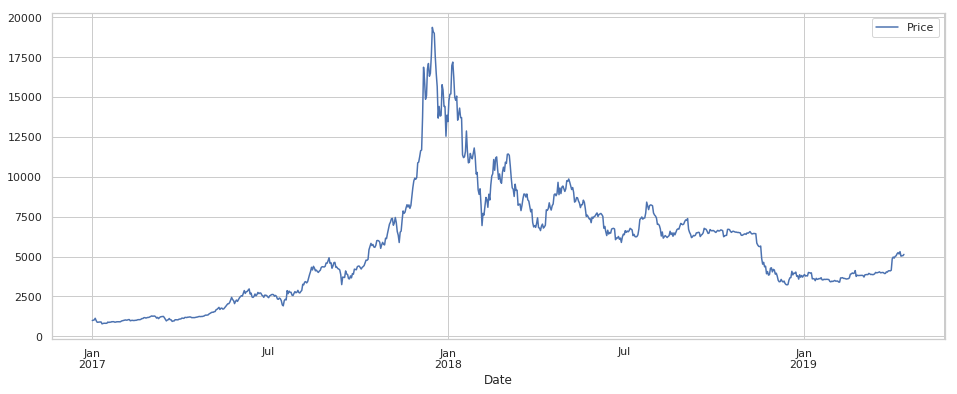

In [7]:
ts.plot(figsize=(16,6))

In [8]:
#Determine spliiting point based on: 

ts = ts[(ts.index >= '2018-12-01')]
print(ts.head(1))

             Price
Date              
2018-12-01  4196.2


#### Function for testing stationarity
Dickey and Fuller (1979) developed a procedure for testing whether a variable has a unit root or,
equivalently, that the variable follows a random walk. The null hypothesis is
always that the variable has a unit root. They differ in whether the null hypothesis includes a drift
term and whether the regression used to obtain the test statistic includes a constant term and time
trend. Source: https://www.stata.com/manuals13/tsdfuller.pdf

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=14) #Trades on weekends
    rolstd = pd.rolling_std(timeseries, window=14)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std Dev')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test Results:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  """


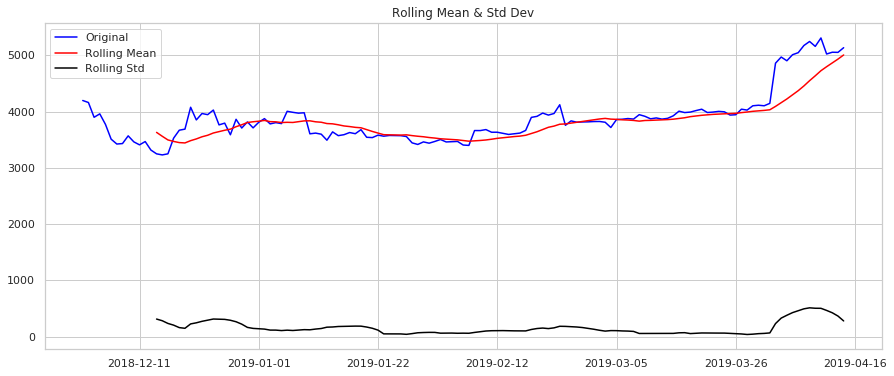

Dickey-Fuller Test Results:
Test Statistic                  -0.125278
p-value                          0.946862
Lags Used                        1.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [10]:
test_stationarity(ts['Price'])

# Making TS Stationary


## Estimating & Eliminating Trend


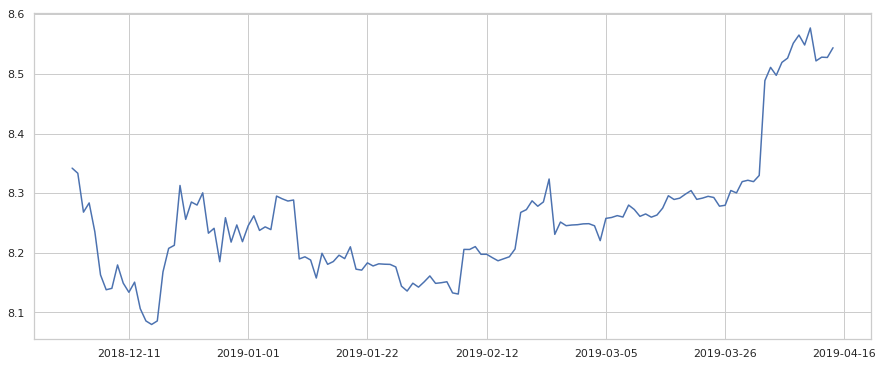

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Smoothing:

### Moving average

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  """Entry point for launching an IPython kernel.


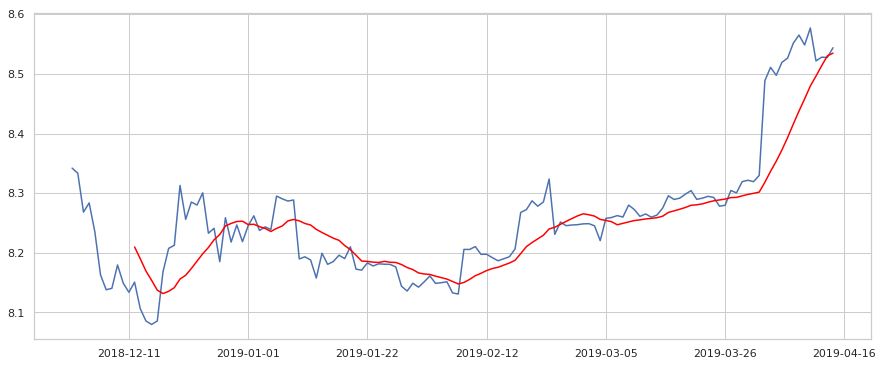

In [12]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
ts_log_moving_avg_diff = ts_log - moving_avg
print(ts_log_moving_avg_diff.head(12))
ts_log_moving_avg_diff.dropna(inplace=True)
print(ts_log_moving_avg_diff.head())

               Price
Date                
2018-12-01       NaN
2018-12-02       NaN
2018-12-03       NaN
2018-12-04       NaN
2018-12-05       NaN
2018-12-06       NaN
2018-12-07       NaN
2018-12-08       NaN
2018-12-09       NaN
2018-12-10       NaN
2018-12-11       NaN
2018-12-12 -0.058978
               Price
Date                
2018-12-12 -0.058978
2018-12-13 -0.083824
2018-12-14 -0.083758
2018-12-15 -0.073962
2018-12-16 -0.051544


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  """


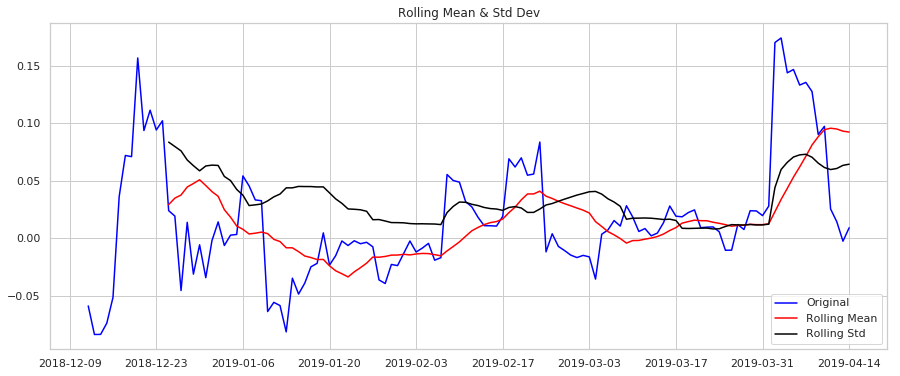

Dickey-Fuller Test Results:
Test Statistic                  -3.995684
p-value                          0.001433
Lags Used                        2.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


In [14]:
test_stationarity(ts_log_moving_avg_diff['Price'])

#### Exponentially Weighted Moving Average (EWMA)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,adjust=True,halflife=12,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


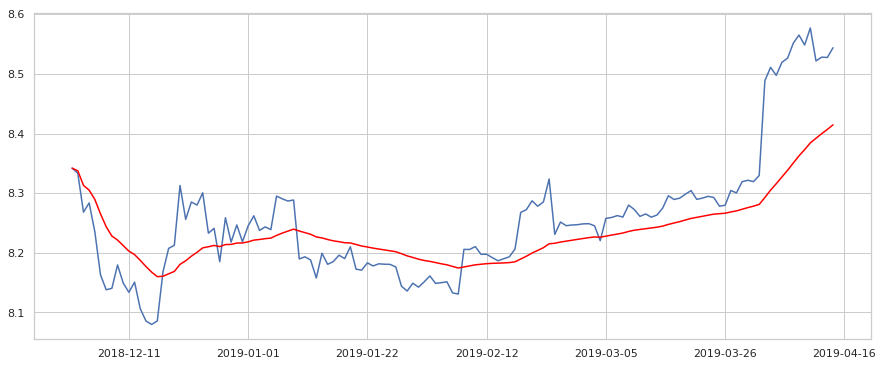

In [15]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  """


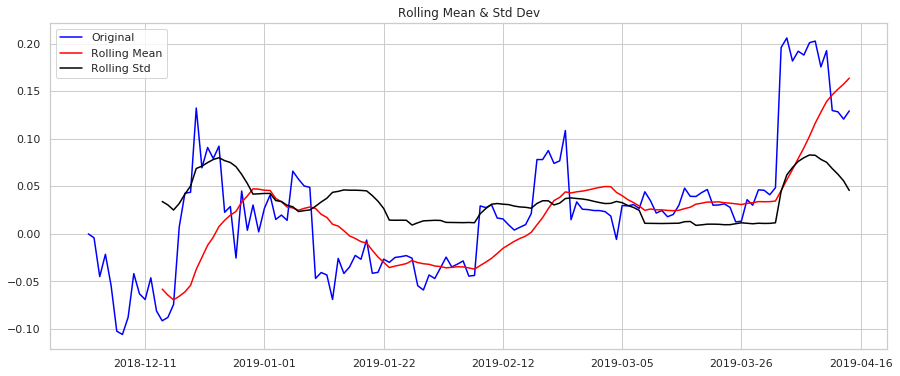

Dickey-Fuller Test Results:
Test Statistic                  -2.182975
p-value                          0.212483
Lags Used                        2.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


In [16]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff['Price'])

## Eliminating Trend & Seasonality

### Differencing:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  """


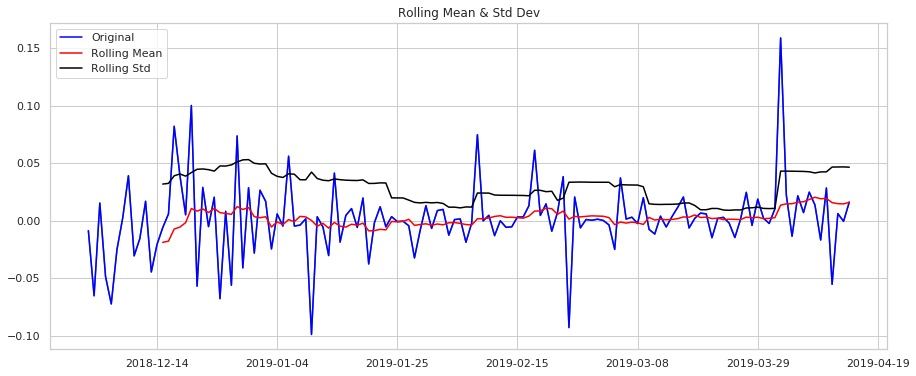

Dickey-Fuller Test Results:
Test Statistic                -1.318226e+01
p-value                        1.189434e-24
Lags Used                      0.000000e+00
Number of Observations Used    1.330000e+02
Critical Value (1%)           -3.480500e+00
Critical Value (5%)           -2.883528e+00
Critical Value (10%)          -2.578496e+00
dtype: float64


In [17]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff['Price'])

### Decomposition:

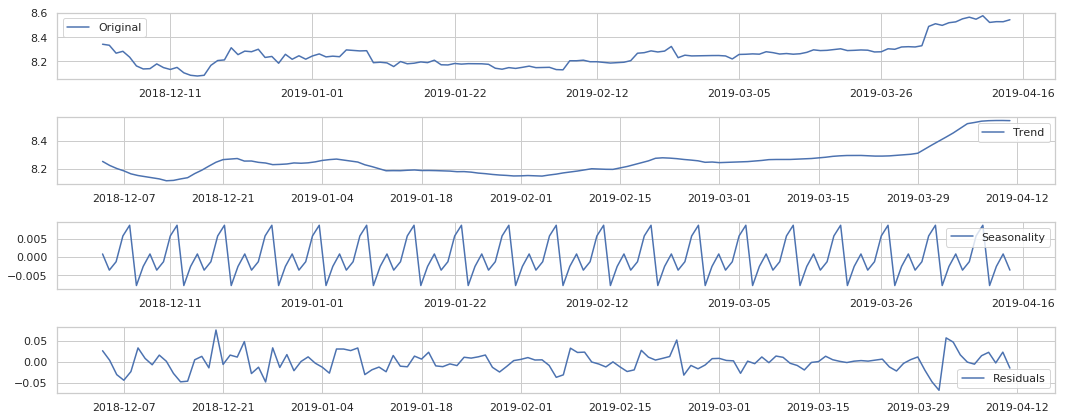

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  """


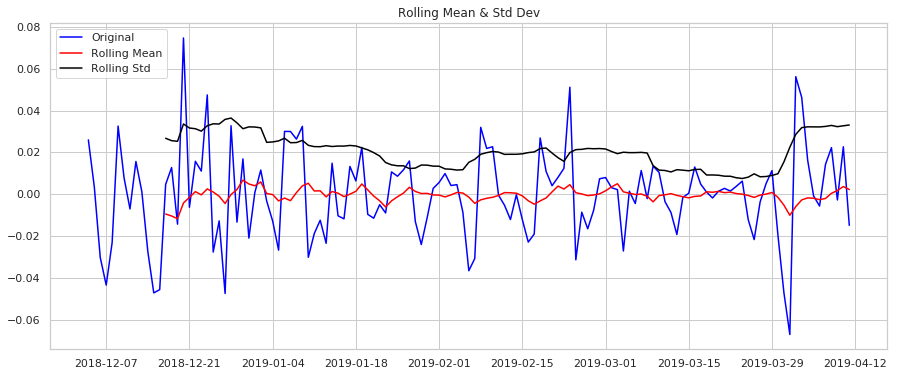

Dickey-Fuller Test Results:
Test Statistic                  -5.228957
p-value                          0.000008
Lags Used                        8.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [19]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose['Price'])

## Forecasting

#### ACF & PACF Plots

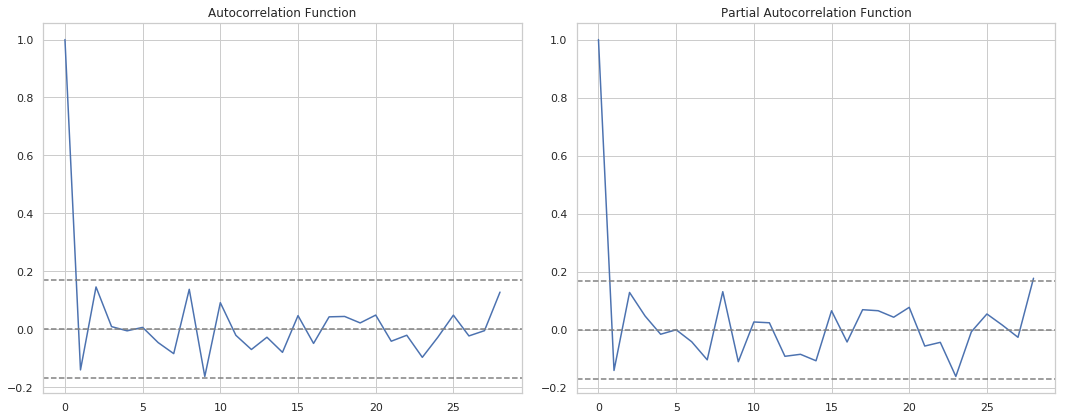

In [20]:
lag_acf = acf(ts_log_diff, nlags=28)
lag_pacf = pacf(ts_log_diff, nlags=28, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Do not read (pertains to non-differenced testing): The slow decay of the autocorrelation function suggests the data follow a long-memory process. 
The duration of shocks is relatively persistent and influence the data several observations ahead. 
This is probably reflected by a smooth trending pattern in the data.

### AR Model:

In [21]:
# from pmdarima import auto_arima
# stepwise_model = auto_arima(ts, start_p=1, start_q=1,max_p=3, max_q=3, m=12,
#                            start_P=0, seasonal=True,
#                            d=1, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True)
# print(stepwise_model.aic())

In [22]:
# #RA model:
# model = ARIMA(ts_log, order=(2, 1, 0))  
# results_AR = model.fit(disp=-1)  
# plt.plot(ts_log_diff)
# plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


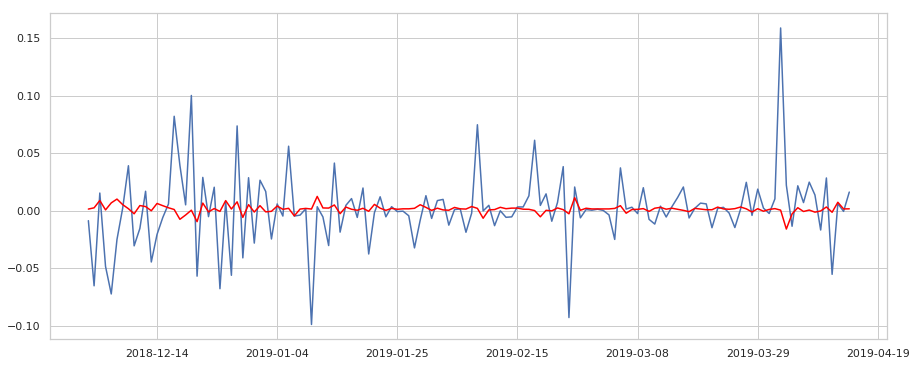

In [24]:
m1 = ARIMA(ts_log, order=(0, 1, 1))  
results_m1 = m1.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_m1.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
print(results_m1)

### Convert to original scale:

In [25]:
predictions_m1_diff = pd.Series(results_m1.fittedvalues, copy=True)
print(predictions_m1_diff.head())
predictions_m1_diff_cumsum = predictions_m1_diff.cumsum()
print(predictions_m1_diff_cumsum.head())

Date
2018-12-02    0.001509
2018-12-03    0.002601
2018-12-04    0.008944
2018-12-05    0.000795
2018-12-06    0.006901
dtype: float64
Date
2018-12-02    0.001509
2018-12-03    0.004109
2018-12-04    0.013053
2018-12-05    0.013848
2018-12-06    0.020749
dtype: float64


In [26]:
predictions_m1_log = pd.DataFrame(ts_log.ix[0:])
predictions_m1_diff_cumsum = pd.DataFrame(predictions_m1_diff_cumsum)
print(predictions_m1_diff_cumsum.tail(2))
print(predictions_m1_log.tail(2))
predictions_m1_log['Price'] = predictions_m1_log['Price'] + predictions_m1_diff_cumsum[0]
print(predictions_m1_log.tail(2))

                   0
Date                
2019-04-13  0.202236
2019-04-14  0.203976
               Price
Date                
2019-04-13  8.527500
2019-04-14  8.543796
               Price
Date                
2019-04-13  8.729736
2019-04-14  8.747773


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


[8.74768468 8.74919336 8.75070203 8.7522107  8.75371937 8.75522804
 8.75673672 8.75824539 8.75975406 8.76126273 8.76277141 8.76428008
 8.76578875 8.76729742]
[6498.71322001 6578.76902219 6645.0792474  6703.78080877 6757.48728076
 6807.60036992 6854.97498838 6900.17787313 6943.60747075 6985.5564586
 7026.24725329 7065.85353027 7104.51395109 7142.3412912 ]


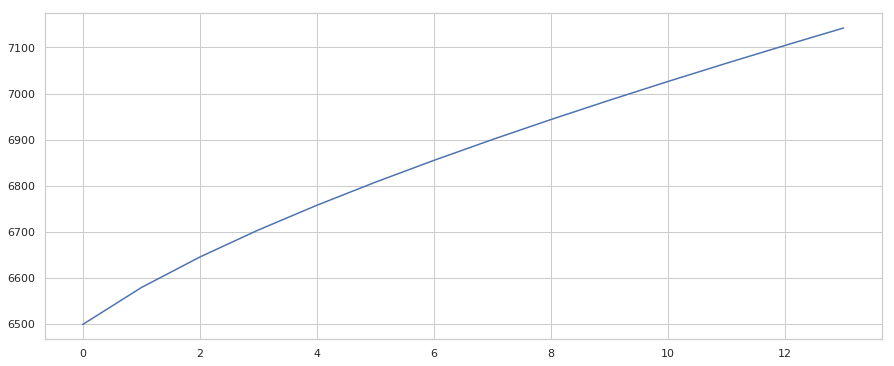

In [27]:
# multi-step out-of-sample forecast
forecast_m1 = results_m1.forecast(steps=14)[0]
print(forecast_m1)
predictions_m1 = np.exp(results_m1.forecast(steps=14)[0] + results_m1.forecast(steps=14)[1])
print(predictions_m1)
plt.plot(predictions_m1)

In [29]:
np.exp(predictions_m1_log).to_csv('arima011.csv')
pd.DataFrame(predictions_m1).to_csv('arima011pred.csv')

In [1]:
# sm1 = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))

NameError: name 'sm' is not defined

## VAR

In [30]:
print('\n Data Types:')
print(df.dtypes)
print(df.head(2))
print("")
print(len(df))


 Data Types:
Price       float64
Open        float64
High        float64
Low         float64
Vol2          int64
Change %     object
dtype: object
             Price   Open    High    Low   Vol2 Change %
Date                                                    
2017-01-01   995.4  963.4  1001.6  956.1  41150    3.33%
2017-01-02  1017.0  995.4  1031.7  990.2  64950    2.17%

834


In [65]:
data = df
test = np.log(data['Price']).diff().dropna()
np.exp(test)

Date
2017-01-02    1.021700
2017-01-03    1.016028
2017-01-04    1.098810
2017-01-05    0.871323
2017-01-06    0.895785
2017-01-07    1.003047
2017-01-08    1.013500
2017-01-09    0.998779
2017-01-10    1.005112
2017-01-11    0.868421
2017-01-12    1.031449
2017-01-13    1.018146
2017-01-14    0.993695
2017-01-15    1.001952
2017-01-16    1.007428
2017-01-17    1.087514
2017-01-18    0.969212
2017-01-19    1.026606
2017-01-20    0.997431
2017-01-21    1.030127
2017-01-22    0.998913
2017-01-23    1.002939
2017-01-24    0.969940
2017-01-25    1.000671
2017-01-26    1.023703
2017-01-27    1.002621
2017-01-28    1.000545
2017-01-29    0.995645
2017-01-30    1.006780
2017-01-31    1.048659
                ...   
2019-03-16    1.020921
2019-03-17    0.993785
2019-03-18    1.002185
2019-03-19    1.006716
2019-03-20    1.006024
2019-03-21    0.985400
2019-03-22    1.002059
2019-03-23    1.003032
2019-03-24    0.998051
2019-03-25    0.985556
2019-03-26    1.001473
2019-03-27    1.025084
2019-0

In [52]:
var1 = VAR(data[['Price', 'Open', 'High', 'Low']])
var_fit1 = var1.fit(1)
var_fit2 = var1.fit(2) #Best, but needs a restricted functrion, not available in python. Lag 4 High is interesting
var_fit3 = var1.fit(3)
var_fit4 = var1.fit(4)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [56]:
var_fit2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Jun, 2019
Time:                     21:31:46
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    35.7615
Nobs:                     832.000    HQIC:                   35.6355
Log likelihood:          -19478.0    FPE:                2.76851e+15
AIC:                      35.5571    Det(Omega_mle):     2.65189e+15
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           49.597749        24.540372            2.021           0.043
L1.Price         1.062774         0.092812           11.451           0.000
L1.Open         -4.311014         2.140550           -2.014           0.044
L1.H

In [70]:
# make prediction
yhat = var_fit4.forecast(var_fit4.y, steps=14)
print(yhat)

[[5183.77152972 5134.76905519 5279.84809307 5109.18653145]
 [5146.11796599 5184.68974686 5257.71261544 5033.19313502]
 [5102.91063362 5146.74953951 5228.52926392 4989.22542495]
 [5067.96678015 5103.11156288 5195.22585326 4936.39639659]
 [5056.65030706 5067.73954253 5187.13229228 4918.75790579]
 [5041.95906096 5056.76433998 5174.57621392 4896.62101425]
 [5031.06695034 5042.04248898 5167.03482416 4881.9664553 ]
 [5024.31219578 5031.12234102 5160.82325301 4868.2936578 ]
 [5022.00129615 5024.31765175 5160.31924475 4862.20578594]
 [5020.5844075  5022.01767946 5159.96674051 4856.92627788]
 [5020.97945934 5020.59048956 5161.62546332 4854.5777939 ]
 [5022.49248637 5020.98444346 5164.07425911 4853.25921503]
 [5025.27222158 5022.49043664 5167.82728707 4853.91939532]
 [5028.63941324 5025.27268936 5171.98425012 4855.35436146]]
